In [22]:
# OPTIONAL SETUP (run once if dependencies are not installed)
# import sys
# import subprocess
# subprocess.run(
#     [sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"],
#     check=True
# )


CompletedProcess(args=['C:\\Users\\Owner\\anaconda3\\python.exe', '-m', 'pip', 'install', '-r', '../requirements.txt'], returncode=0)

In [2]:
from pathlib import Path
from zenodo_get import download
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

## Introduction
   
   This notebook demonstrates how to access and visualize the Zenodo-archived internal tide parameter database. The database contains precomputed M2 internal tide parameters (vertical modes 1-10) on a global 0.25° grid, including:
   
   - Vertical mode structures
   - Wave properties (phase speeds, group speeds, wavelengths)
   - Conversion ratios for calculating energy and flux from SSH amplitudes
   

#### Download the mode-1 M$_2$ internal-tide parameter dataset

The precomputed mode-1 M$_2$ internal-tide parameters derived from WOA23 are archived on Zenodo at:  
https://doi.org/10.5281/zenodo.18423546

Zenodo provides a lightweight Python interface, **`zenodo_get`**, which allows users to programmatically download individual files from a Zenodo record. In the example below, we download the mode-1 internal-tide parameter file.

*Note:* this file is approximately 1 GB in size and may take several minutes to download, depending on network speed.


In [3]:
doi = "10.5281/zenodo.18423546"
mode1_fn = "mode01_internal_tide_parameters.nc"
data_dir = Path(r"C:\JOSS\data") # or relative path, e.g. Path("data/zenodo")


In [3]:
download(
    record_or_doi=doi,
    output_dir=data_dir,
    file_glob=mode1_fn,
)


2026-02-02 10:26:17.953 | INFO     | zenodo_get.zget:_zenodo_download_logic:306 - Output directory: C:\JOSS\data
2026-02-02 10:26:19.934 | INFO     | zenodo_get.zget:_zenodo_download_logic:404 - Title: Global M2 internal tide parameters for modes 1-10 derived from the World Ocean Atlas 2023 (WOA23)
2026-02-02 10:26:19.935 | INFO     | zenodo_get.zget:_zenodo_download_logic:416 - Total size: 1.1 GB
2026-02-02 10:26:19.936 | INFO     | zenodo_get.zget:_zenodo_download_logic:417 - Number of files: 1
2026-02-02 10:52:23.075 | SUCCESS  | zenodo_get.zget:_zenodo_download_logic:461 - All specified files have been processed.


## Internal-Tide Parameters

This dataset provides precomputed background stratification and linear internal-tide parameters derived from the **World Ocean Atlas 2023 (WOA23)**, on a $0.25^\circ \times 0.25^\circ$ global longitude–latitude grid.

For the full theoretical derivation and formulation of these parameters, see the companion manuscript Appendix A (DOI: to be inserted after the preprint is released).

---

## Coordinates

The coordinate system follows the WOA23 dataset.

- **`lon`** (degrees): longitude on a $0.25^\circ$ grid, spanning $[-180, 180]$.
- **`lat`** (degrees): latitude on a $0.25^\circ$ grid, spanning $[-90, 90]$.
- **`pmid`** (dbar): mid-point pressure levels used for vertical discretization.  
  WOA23 provides 102 standard depth levels; to compute vertical normal modes, pressure is defined at the 101 mid-point levels between adjacent depth levels.

---

## Background stratification

- **`N2`** ($\mathrm{s^{-2}}$) (`lon`, `lat`, `pmid`):  
  Stratification $N^2(z)$ derived from WOA23 climatological temperature and salinity profiles.

  We use the decadal-mean $0.25^\circ$ gridded temperature and salinity datasets distributed by NOAA NCEI via the Coasts & Oceans THREDDS Data Server.  
  Temperature is obtained from:  
  https://www.ncei.noaa.gov/thredds-ocean/catalog/woa23/DATA/temperature/netcdf/decav/0.25/catalog.html  

  Salinity is obtained from:  
  https://www.ncei.noaa.gov/thredds-ocean/catalog/woa23/DATA/salinity/netcdf/decav/0.25/catalog.html  

  $N^2$ is computed from these climatologies using the **gsw (Gibbs SeaWater)** Python package, following the TEOS-10 standard:  
  https://teos-10.github.io/GSW-R/

- **`dz`** (`pmid`):  
  Vertical layer thickness corresponding to each pressure midpoint.

---

## Vertical normal modes (linear internal-wave theory)

The vertical modes and eigenspeeds (`wmodes`, `pmodes`, `ce`) are obtained by solving the linear internal-wave eigenvalue problem, as implemented in the open-source dynmodes package:  
https://github.com/sea-mat/dynmodes

- **`wmodes`** (`lon`, `lat`, `pmid`) (dimensionless):  
  Vertical structure functions for vertical velocity $w'$ and isopycnal displacement $\eta'$, derived from the linearized hydrostatic internal-wave equations.

- **`pmodes`** (`lon`, `lat`, `pmid`) (dimensionless):  
  Vertical structure

- **`ce`** (`lon`, `lat`) ($\mathrm{m\,s^{-1}}$):  
  Eigen speed.

---

## wave properties

- **`wavelength`** (`lon`, `lat`) (m):  
  Horizontal wavelength.

- **`k`** (`lon`, `lat`) ($\mathrm{m^{-1}}$):  
  Horizontal wavenumber magnitude.

- **`cp`** (`lon`, `lat`) ($\mathrm{m\,s^{-1}}$):  
  Phase speed.

- **`cg`** (`lon`, `lat`) ($\mathrm{m\,s^{-1}}$):  
  Group speed.

- **`ratio_a_eta`** (`lon`, `lat`) (dimensionless):  
  Ratio of surface amplitude to maximum vertical displacement amplitude.

- **`PE`** (`lon`, `lat`) (J m$^{-2}$ m$^{-2}$):  
  Ratio of depth-integrated available potential energy to surface amplitude squared.

- **`KE`** (`lon`, `lat`) (J m$^{-2}$ m$^{-2}$):  
  Ratio of depth-integrated kinetic energy to surface amplitude squared.

- **`E`** (`lon`, `lat`) (J m$^{-2}$ m$^{-2}$):  
  Ratio of total depth-integrated energy to surface amplitude squared, defined as E = PE + KE.

- **`F`** (`lon`, `lat`) (W m$^{-1}$ m$^{-2}$):  
  Ratio of depth-integrated horizontal energy flux magnitude to surface amplitude squared.

In [4]:
ds_woa23 = xr.open_dataset(os.path.join(data_dir, mode1_fn), engine='netcdf4')
display(ds_woa23)

<xarray.Dataset>
Dimensions:      (lon: 1440, lat: 720, pmid: 101)
Coordinates:
  * pmid         (pmid) float64 2.527 7.582 12.64 ... 5.477e+03 5.581e+03
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    mode         int64 ...
Data variables: (12/14)
    N2           (lon, lat, pmid) float64 ...
    ce           (lon, lat) float64 ...
    wmodes       (lon, lat, pmid) float64 ...
    pmodes       (lon, lat, pmid) float64 ...
    wavelength   (lon, lat) float64 ...
    cp           (lon, lat) float64 ...
    ...           ...
    dz           (pmid) float32 ...
    ratio_a_eta  (lon, lat) float64 ...
    PE           (lon, lat) float64 ...
    KE           (lon, lat) float64 ...
    E            (lon, lat) float64 ...
    F            (lon, lat) float64 ...

#### plot ce (eigenspeed), cp (phase speed), and cg (group speed)

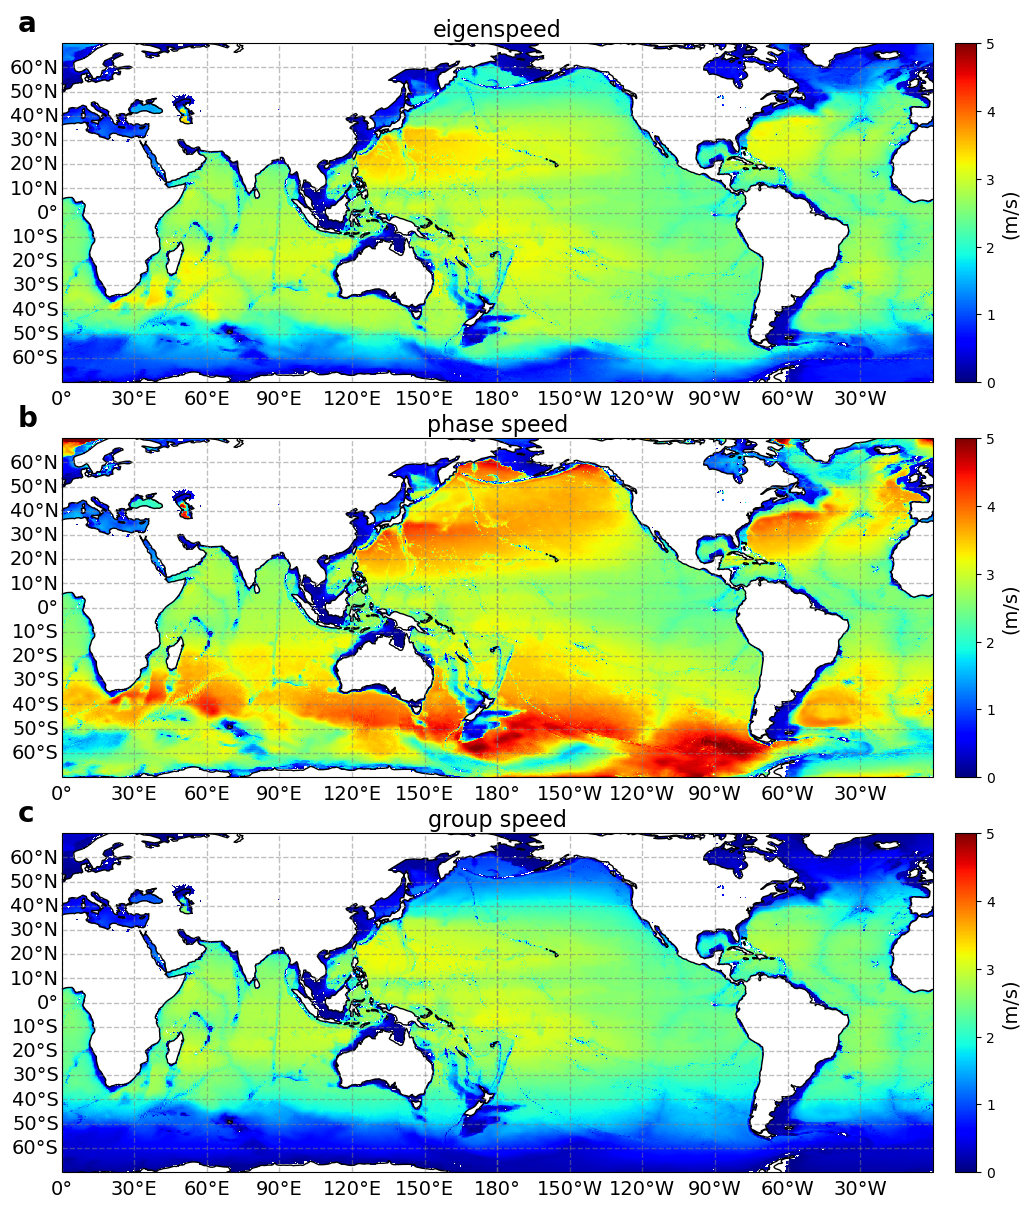

In [32]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Variables to plot
variables = ['ce','cp', 'cg']
labels = [r'(m/s)', r'(m/s)', r'(m/s)']
titles = ['eigenspeed','phase speed','group speed']
scales = [1, 1, 1]  # Scaling factors for each subplot
norms = [
    mcolors.Normalize(vmin=0, vmax=5),  # Wavelength (linear scale)
    mcolors.Normalize(vmin=0, vmax=5),  # Ratio (log scale)
    mcolors.Normalize(vmin=0, vmax=5),  # Energy ratio (log scale)
]

# mcolors.LogNorm(vmin=0, vmax=5),  # Energy ratio (log scale)
colorbar_ticks = [
    [0, 1,2,3,4,5],
    [0, 1,2,3,4,5],
    [0, 1,2,3,4,5],
]


# Loop through each variable to plot
for i, var in enumerate(variables):
    data = ds_woa23[var][:,:] * scales[i]
    data = data.where(data != 0)

    im = axs[i].pcolormesh(ds_woa23['lon'], ds_woa23['lat'], data.T, transform=ccrs.PlateCarree(),
                           shading='auto', cmap='jet', norm=norms[i])
    
    axs[i].set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
    axs[i].coastlines()
    axs[i].set_title(titles[i], fontsize=16, pad=5)

    # Customizing gridlines using MultipleLocator
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    gl.xlocator = mticker.MultipleLocator(30)
    gl.ylocator = mticker.MultipleLocator(10)
    gl.top_labels = False
    gl.right_labels = False
    
    # Add subplot label ('a', 'b', 'c', 'd') in bold
    label = chr(97 + i)  # 'a', 'b', 'c', 'd'
    axs[i].text(-0.05, 1.1, label, transform=axs[i].transAxes, size=20, weight='bold', va='top')

    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical', pad=0.02, aspect=16, ticks=colorbar_ticks[i])
    cbar.set_label(labels[i], fontsize=14)
    # cbar.ax.tick_params(labelsize=14)
    if isinstance(norms[i], mcolors.LogNorm):
        cbar.ax.set_yscale('log')
        cbar.ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        cbar.ax.yaxis.set_minor_formatter(mticker.NullFormatter())
        cbar.set_ticks(colorbar_ticks[i])
        cbar.ax.tick_params(labelsize=14)
    
# Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.1, top=0.95)
plt.tight_layout()
plt.show()

#### plot 
a) wavelength
b) Ratio of the sea surface amplitude to maximal interior displacements
c) E: Ratio of total depth-integrated energy to surface amplitude squared
d) F: Ratio of depth-integrated horizontal energy flux magnitude to surface amplitude squared

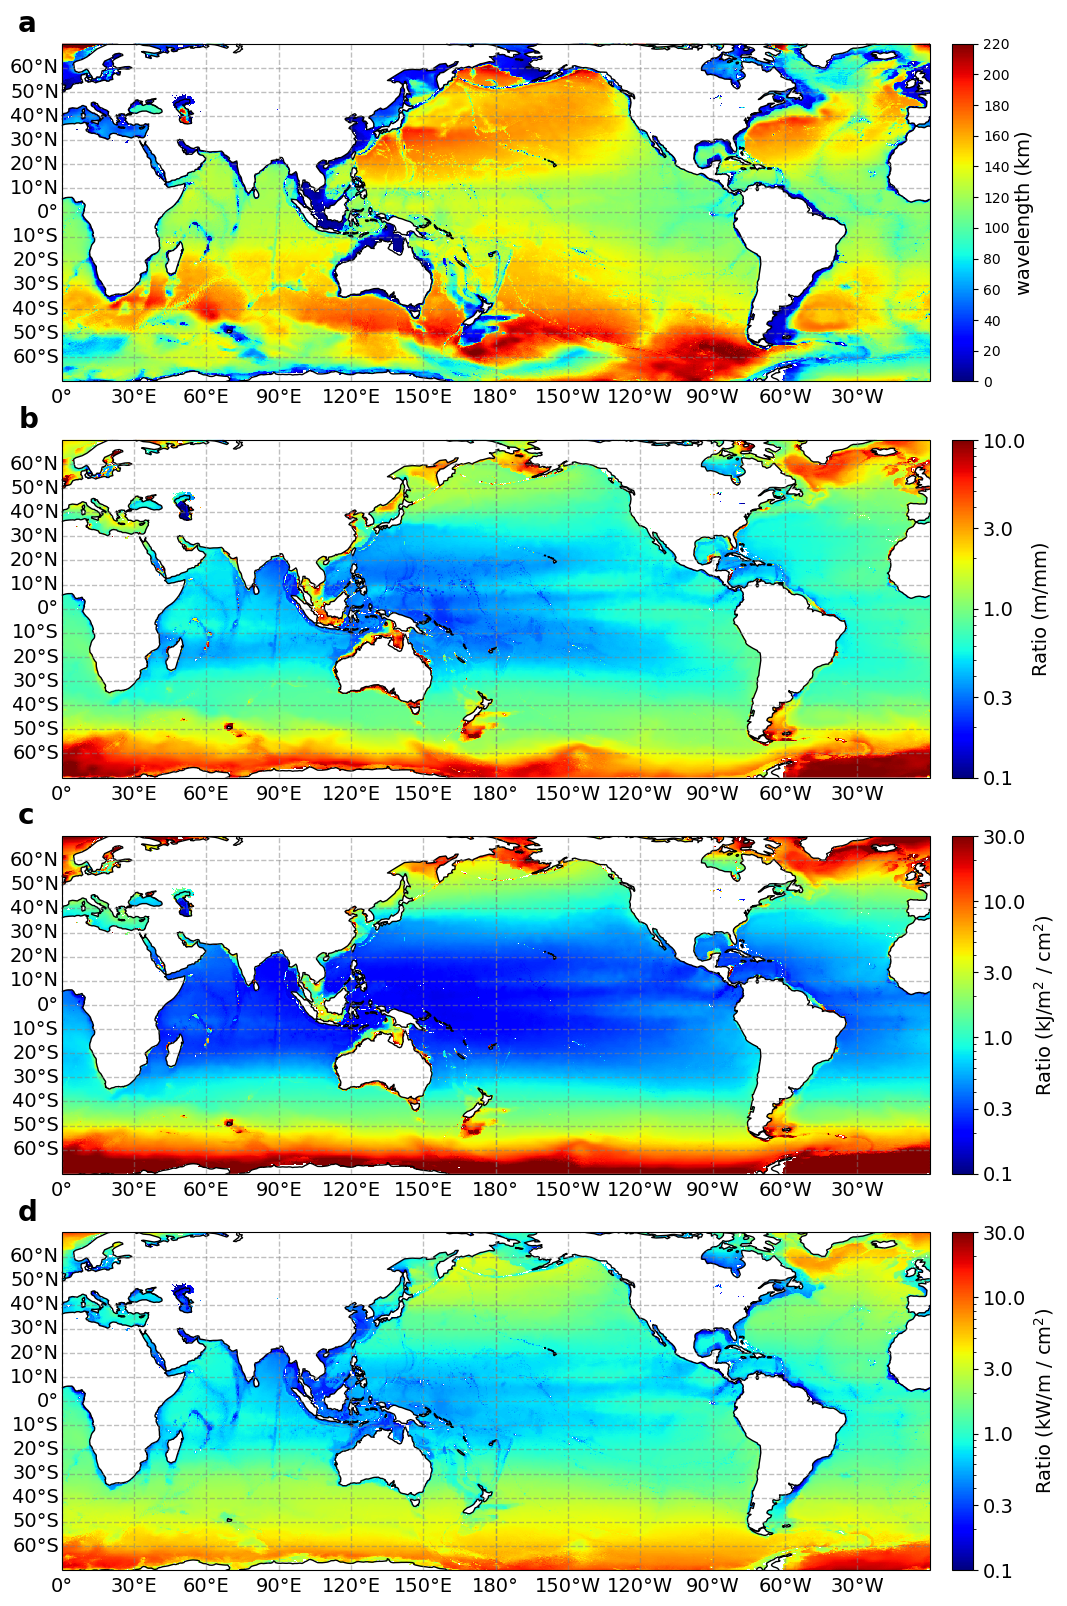

In [48]:
ds_woa23['ratio_eta_a'] = 1/ds_woa23['ratio_a_eta']

# phase speed. scale = 1, clim = [-5,5]
mode = 1
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 16),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Variables to plot
variables = ['wavelength', 'ratio_eta_a', 'E', 'F']
labels = [r'wavelength (km)', r'Ratio (m/mm)', r'Ratio (kJ/m$^2$ / cm$^2$)', r'Ratio (kW/m / cm$^2$)']
scales = [1e-3, 1e-3, 1e-7, 1e-7]  # Scaling factors for each subplot
# clims = [[1e-1, 220], [1e-3, 10], [1e-7, 12], [1e-7, 12]]
norms = [
    mcolors.Normalize(vmin=0, vmax=220),  # Wavelength (linear scale)
    mcolors.LogNorm(vmin=0.1, vmax=10),  # Ratio (log scale)
    mcolors.LogNorm(vmin=0.1, vmax=30),  # Energy ratio (log scale)
    mcolors.LogNorm(vmin=0.1, vmax=30)   # Energy flux ratio (log scale)
]
colorbar_ticks = [
    [0, 20, 40, 60, 80, 100, 120, 140,160,180, 200, 220],
    [0.1, 0.3, 1, 3, 10],
    [0.1, 0.3, 1, 3, 10, 30],
    [0.1, 0.3, 1, 3, 10, 30]
]


# Loop through each variable to plot
for i, var in enumerate(variables):
    data = ds_woa23[var] * scales[i]
    data = data.where(data != 0)

    im = axs[i].pcolormesh(ds_woa23['lon'], ds_woa23['lat'], data.T, transform=ccrs.PlateCarree(),
                           shading='auto', cmap='jet', norm=norms[i])
    
    axs[i].set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
    axs[i].coastlines()

    # Customizing gridlines using MultipleLocator
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    gl.xlocator = mticker.MultipleLocator(30)
    gl.ylocator = mticker.MultipleLocator(10)
    gl.top_labels = False
    gl.right_labels = False
    
    # Add subplot label ('a', 'b', 'c', 'd') in bold
    label = chr(97 + i)  # 'a', 'b', 'c', 'd'
    axs[i].text(-0.05, 1.1, label, transform=axs[i].transAxes, size=20, weight='bold', va='top')

    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical', pad=0.02, aspect=16, ticks=colorbar_ticks[i])
    cbar.set_label(labels[i], fontsize=14)
    # cbar.ax.tick_params(labelsize=14)
    if isinstance(norms[i], mcolors.LogNorm):
        cbar.ax.set_yscale('log')
        cbar.ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        cbar.ax.yaxis.set_minor_formatter(mticker.NullFormatter())
        cbar.set_ticks(colorbar_ticks[i])
        cbar.ax.tick_params(labelsize=14)
      
# Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.1, top=0.95)

plt.tight_layout()
plt.show()

#### specify lon and lat
longitude should be in the range [-180, 180], since the WOA23-based lookup table uses this convention.

In [6]:
lon_example, lat_example = -35, -35.5

plot

(a) shows the background stratification \(N^2\).  
(b) shows the first vertical normal mode of vertical velocity and isopycnal displacement (\(w', \eta'\)).  
(c) shows the first vertical normal mode of horizontal velocity and pressure (\(u', v', p'\)).  
All vertical modes are normalized by their maximum absolute value to lie within \([-1,\,1]\).


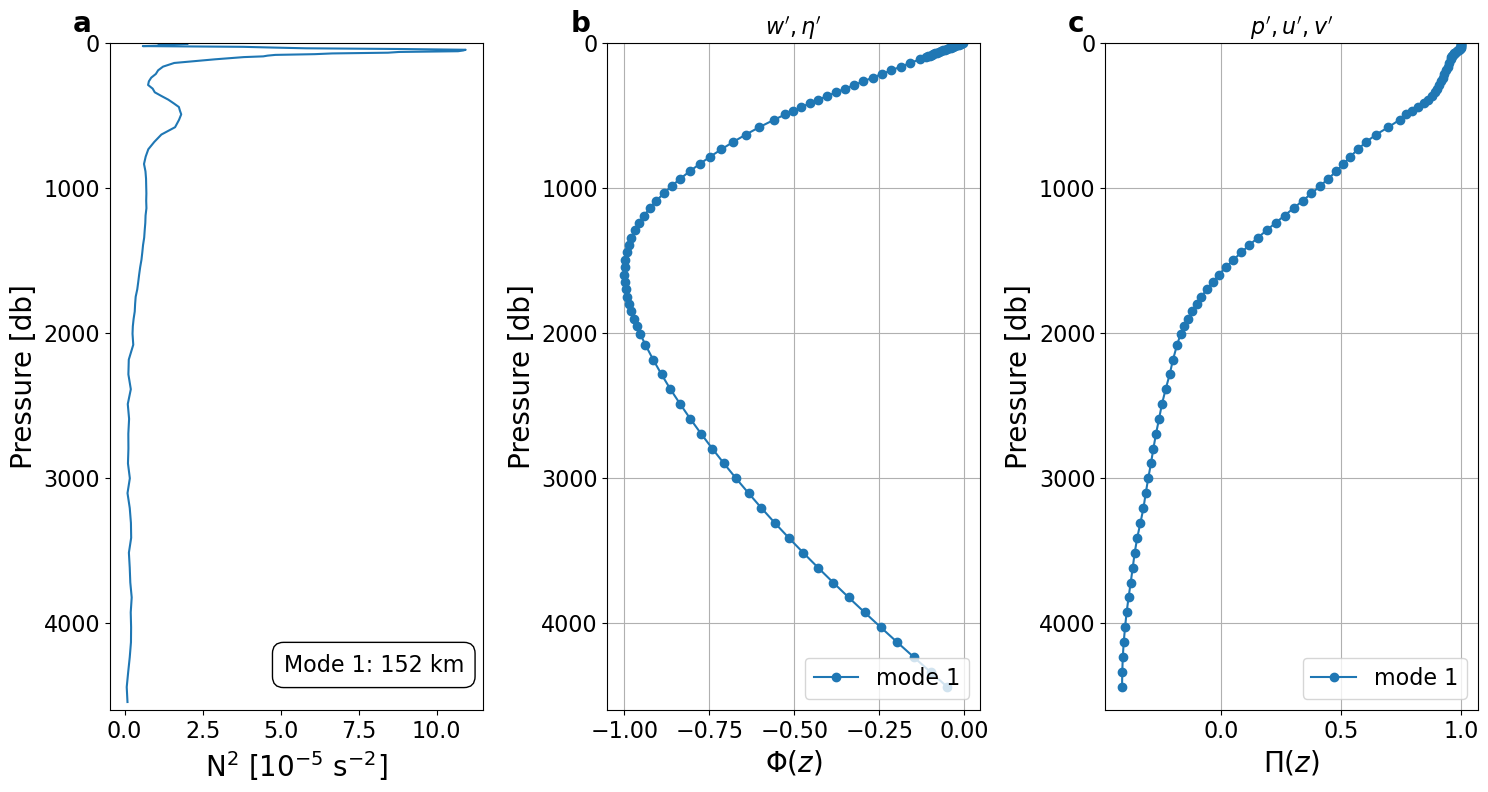

In [45]:
max_abs_wmodes = abs(ds_woa23['wmodes']).max(dim='pmid')
ds_woa23['wmodes'] = ds_woa23['wmodes'] / max_abs_wmodes

N2 = ds_woa23['N2'].sel(lon=lon_example, lat=lat_example, method='nearest').values
wmodes = ds_woa23['wmodes'].sel(lon=lon_example, lat=lat_example, method='nearest').values
pmodes = ds_woa23['pmodes'].sel(lon=lon_example, lat=lat_example, method='nearest').values
wavelengths = ds_woa23['wavelength'].sel(lon=lon_example, lat=lat_example, method='nearest').values.astype(int)
pmid = ds_woa23['pmid'].values


fig, axs = plt.subplots(1, 3, figsize=(15, 8)) 

# Plotting N2 on the first subplot
axs[0].plot(1e5 * N2, pmid)
axs[0].invert_yaxis()
axs[0].set_ylim([0, 4600])
axs[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
# axs[0].set_xlabel(r'N² [s$^{-2}$]', fontsize=20)
axs[0].set_xlabel(r'N$^2$ [$10^{-5}$ s$^{-2}$]', fontsize=20)
axs[0].set_ylabel('Pressure [db]', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=16)
legend_text = '\n'.join([f'Mode 1: {1e-3 * wavelengths:.0f} km'])
axs[0].text(0.95, 0.05, legend_text, transform=axs[0].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            fontsize=16, bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='black'))
axs[0].invert_yaxis()

# Plotting W modes on the second subplot
n_modes_to_plot = 1  # Adjust based on how many modes you want to plot
for i in range(n_modes_to_plot):
    axs[1].plot(wmodes, pmid, marker='o', linestyle='-', label=f'mode {i+1}')
axs[1].set_title(r'$w^\prime,\eta^\prime$', fontsize=16)
axs[1].set_xlabel(r'$\Phi(z)$', fontsize=20)
axs[1].set_ylabel('Pressure [db]', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].set_ylim([0, 4600])
axs[1].grid(True)
axs[1].legend(loc='lower right', fontsize=16)
axs[1].invert_yaxis()

# Plotting P modes on the third subplot
for i in range(n_modes_to_plot):
    axs[2].plot(pmodes, pmid, marker='o', linestyle='-', label=f'mode {i+1}')
axs[2].set_title(r'$p^\prime, u^\prime, v^\prime$', fontsize=16)
axs[2].set_xlabel(r'$\Pi(z)$', fontsize=20)
axs[2].set_ylabel('Pressure [db]', fontsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=16)
axs[2].set_ylim([0, 4600])
axs[2].grid(True)
axs[2].legend(loc='lower right', fontsize=16)
axs[2].invert_yaxis()

subplot_labels = ['a', 'b', 'c']
for i, ax in enumerate(axs):
    ax.text(-0.1, 1.05, subplot_labels[i], transform=ax.transAxes,
            size=20, weight='bold', va='top')
    
plt.tight_layout()
plt.show()

In [16]:
# Extract all parameters at the example location
lon_example = -35.0
lat_example = -35.5

# Get wavenumber
k = ds_woa23['k'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"Horizontal wavenumber (k): {1e3 * k:.2f} rad/km")

# Get phase speed
cp = ds_woa23['cp'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"Phase speed (cp): {cp:.2f} m/s")

# Get group velocity
cg = ds_woa23['cg'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"Group velocity (cg): {cg:.2f} m/s")

# Get conversion ratio: surface amplitude to max vertical displacement
ratio_a_eta = ds_woa23['ratio_a_eta'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"Ratio a/η (surface amplitude to max displacement): {ratio_a_eta:.2f}")

# Get conversion ratio: surface amplitude squared to depth-integrated potential energy
PE = ds_woa23['PE'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"PE conversion factor (SSH amplitude² to depth-integrated PE): {PE:.2e} J/m²")

# Get conversion ratio: surface amplitude squared to depth-integrated kinetic energy
KE = ds_woa23['KE'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"KE conversion factor (SSH amplitude² to depth-integrated KE): {KE:.2e} J/m²")

# Get conversion ratio: surface amplitude squared to depth-integrated total energy
E = ds_woa23['E'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"E conversion factor (SSH amplitude² to depth-integrated total energy): {E:.2e} J/m²")

# Get conversion ratio: surface amplitude squared to energy flux
F = ds_woa23['F'].sel(lon=lon_example, lat=lat_example, method='nearest').values
print(f"F conversion factor (SSH amplitude² to depth-integrated horizontal energy flux): {F:.2e} W/m")

# Optional: Print location info
print(f"\nLocation: {lon_example}°w, {lat_example}°S")
print(f"(Nearest grid point in dataset: {ds_woa23['lon'].sel(lon=lon_example, method='nearest').values:.2f}°E, "
      f"{ds_woa23['lat'].sel(lat=lat_example, method='nearest').values:.2f}°N)")

Horizontal wavenumber (k): 0.04 rad/km
Phase speed (cp): 3.40 m/s
Group velocity (cg): 2.17 m/s
Ratio a/η (surface amplitude to max displacement): 0.00
PE conversion factor (SSH amplitude² to depth-integrated PE): 2.93e+06 J/m²
KE conversion factor (SSH amplitude² to depth-integrated KE): 6.23e+06 J/m²
E conversion factor (SSH amplitude² to depth-integrated total energy): 9.16e+06 J/m²
F conversion factor (SSH amplitude² to depth-integrated horizontal energy flux): 1.99e+07 W/m

Location: -35.0°w, -35.5°S
(Nearest grid point in dataset: -34.88°E, -35.38°N)
